Scrap work of implementing methods provided by Jamie into pipeline-able functions (a.k.a. this is the precursor to fill_missing.py and daily_stats.py)

In [2]:
import numpy as np
import pandas as pd

# import warnings
# warnings.filterwarnings('ignore')

# Filling in missing values

In [23]:
data = pd.read_excel('../data/ahr414_glucose_sample.xlsx')
patIDs = data.PatientId.unique().tolist() #temp to get just the second patient ID (will be used in the line below)
# data = data.loc[data.PatientId == patIDs[1]] #narrow dataframe down to just 1 patient

conv_time = data.GlucoseDisplayTime.dt.time #save the display-time

'''turning the time of day attribute into a float value where whole numbers are hours and fractions are minutes and seconds'''
timeOfday = pd.Series(dtype=float)
datedisplay = pd.Series(dtype=float)
for i in conv_time.index:
    timeOfday.at[i] = conv_time[i].hour + conv_time[i].minute/60 + conv_time[i].second/3600
    datedisplay.at[i] = data.GlucoseDisplayTime[i].date()

#timeOfday = cgm_functions.date2float(data.GlucoseDisplayTime.dt.time)
data['GlucoseDisplayTimeNoDay'] = timeOfday
data['GlucoseDisplayDate'] = datedisplay

### functions

In [4]:
'''Insert Row into Dataframe'''
def insertRow(row_number, df, row_value):
    # Starting value of upper half
    start_upper = 0
  
    # End value of upper half
    end_upper = row_number
  
    # Start value of lower half
    start_lower = row_number
  
    # End value of lower half
    end_lower = df.shape[0]
  
    # Create a list of upper_half index
    upper_half = [*range(start_upper, end_upper, 1)]
  
    # Create a list of lower_half index
    lower_half = [*range(start_lower, end_lower, 1)]
  
    # Increment the value of lower half by 1
    lower_half = [x.__add__(1) for x in lower_half]
  
    # Combine the two lists
    index_ = upper_half + lower_half
  
    # Update the index of the dataframe
    df.index = index_
  
    # Insert a row at the end
    df.loc[row_number] = row_value
   
    # Sort the index labels
    df = df.sort_index()
  
    # return the dataframe
    return df

In [5]:
'''Find Unrecorded 5-minute Sample'''
def fillUnrecorded(df):
    # Description: Find gaps in sampling and insert samples that fill the time-gap with a missing value
    #     INPUTS: 
    #         df: dataframe of the raw data that hasn't replaced zeros with NaNs
    #     OUTPUTS:
    #         df_filled: dataframe with inserted timestamps
    
    df['inserted'] = 0
    stitched_df = pd.DataFrame(columns = df.columns)

    df = df.sort_values("GlucoseDisplayTime", ascending=True) \
           .reset_index(drop=True) #bit of cleanup
    display_times = df.GlucoseDisplayTime

    
    for i in range(1, len(display_times)-1):
        delta_sec = (display_times[i] - display_times[i-1]).seconds
        steps_missing = int(np.round(delta_sec / 300)-1) # how many 5-minute samples are missing #may come back to clean

        if steps_missing > 0:
            for step in range(steps_missing):
                row_number = i + (step-1)
                row_data = df.iloc[i-1]
                time_feats = ['RecordedSystemTime', 'RecordedDisplayTime', 'GlucoseSystemTime', 'GlucoseDisplayTime']
                row_data[time_feats] = row_data[time_feats] + np.timedelta64(5*(step+1), 'm')
                row_data['inserted'] = 1
                subset_fill = insertRow(row_number, df, row_data)
        else:
            subset_fill = df
    stitched_df = pd.concat([stitched_df, subset_fill])
    

    subset_fill.sort_values("GlucoseDisplayTime", ascending=True, inplace=True)
    subset_fill.reset_index(drop=True, inplace=True)
                
    return stitched_df

In [6]:
'''Convert Zero Values to NaN'''
def ZeroToNaN(df):
    # Description: Replace the zero values in the data with missing (NaN) values for interpolation methods
    #     INPUTS
    #        df: dataframe of raw data that has incorrectly labeled zero values for CGM values
    #     OUTPUTS
    #        df_missing: dataframe with zeros converted to NaNs
    
    df['missing'] = pd.Series(0, df.index)
    df.Value.replace(0, np.nan, inplace=True)

    missing_label = df[df.Value.isnull()].index
    df['missing'].iloc[missing_label] = 1
         
    return df

In [15]:
'''Interpolate Missing Data'''
def interpolateMissing(df):
    # Description goes here

    df['missing'] = pd.Series(0, df.index)
    df.Value = df.Value.replace(0, np.nan)
    missing_label = df[df.Value.isnull()].index
    df['missing'].iloc[missing_label] = 1
    
    df = df.sort_values("GlucoseDisplayTime", ascending=True) \
           .reset_index(drop=True)
    df.Value = df.Value.interpolate(method='pchip')
    
    missing_vals = df.loc[df.missing == 1]
    sigma = np.sqrt(np.std(df.Value))
    
    for i in missing_vals.index:
        jiggle = sigma*np.random.randn()
        df.at[i, 'Value'] = df.at[i, 'Value'] + jiggle
        
    return df.dropna(axis=0, subset="Value")

## put all together

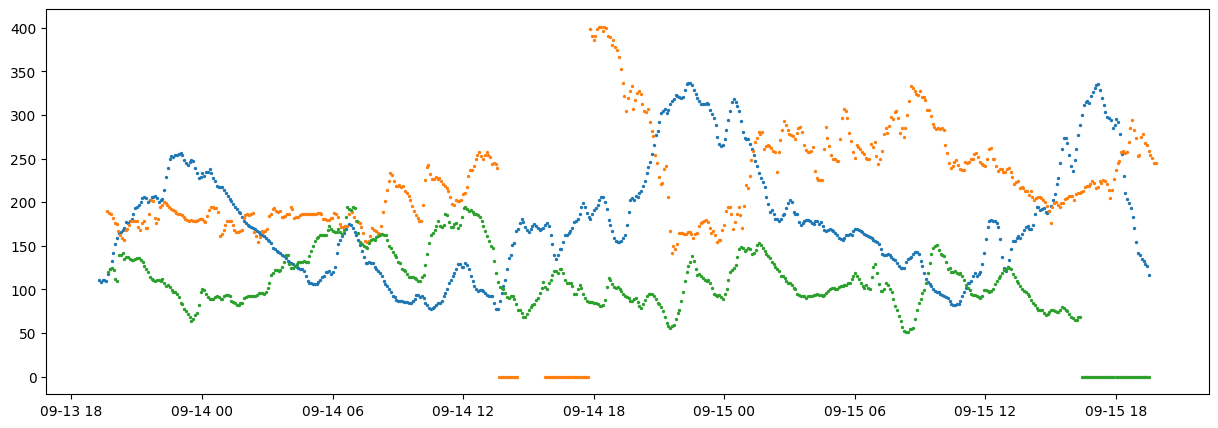

In [24]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
for i in patIDs:
    temp  = data[data.PatientId == i]
    plt.scatter(temp.GlucoseDisplayTime, temp.Value, s=2)

In [25]:
patIDs = data.PatientId.unique().tolist() #make list of patient IDs
for i in patIDs:
    # singlePatient = data.loc[data.PatientId == i] #work on just one slice at a time
    interp = interpolateMissing(ZeroToNaN(fillUnrecorded(data.loc[data.PatientId == i])))
    print(interp.shape)
    data = data[data.PatientId != i]
    data = pd.concat([data,interp])
data

C:\Users\ljoe\AppData\Local\Temp\ipykernel_6776\2860937804.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inserted'] = 0
C:\Users\ljoe\AppData\Local\Temp\ipykernel_6776\462466693.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['missing'].iloc[missing_label] = 1
C:\Users\ljoe\AppData\Local\Temp\ipykernel_6776\2072436936.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

(580, 28)


C:\Users\ljoe\AppData\Local\Temp\ipykernel_6776\1394295105.py:31: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df.loc[row_number] = row_value
C:\Users\ljoe\AppData\Local\Temp\ipykernel_6776\2860937804.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row_data[time_feats] = row_data[time_feats] + np.timedelta64(5*(step+1), 'm')
C:\Users\ljoe\AppData\Local\Temp\ipykernel_6776\2860937804.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row_data[time_feats] = row_data[time_feats] + np.tim

(579, 28)
(576, 28)


,PostDate,IngestionDate,PostId,PostTime,PatientId,Stream,SequenceNumber,TransmitterNumber,ReceiverNumber,RecordedSystemTime,...,Status,TrendArrow,TrendRate,IsBackFilled,InternalStatus,SessionStartTime,GlucoseDisplayTimeNoDay,GlucoseDisplayDate,inserted,missing
0,2022-09-14,2022-09-14,fyQ0wOxwB8sthzC75TWKpqdrCMCLq+W1wBg9s7MHVcE=,2022-09-14 00:26:00.264,tHu8WPnIffml5CL+AbOBkXcbFApQnP06KdrHbjinta4=,Phone7,1663115129,XFgG633aV9tw5Gclf1WB6nmt9Wgv4nHJjXfRQIAOfsg=,NaN,2022-09-13 23:16:01.009,...,NaN,Flat,0.2,False,6,5137335,19.262500,2022-09-13,0,0.0
1,2022-09-14,2022-09-14,fyQ0wOxwB8sthzC75TWKpqdrCMCLq+W1wBg9s7MHVcE=,2022-09-14 00:26:00.264,tHu8WPnIffml5CL+AbOBkXcbFApQnP06KdrHbjinta4=,Phone7,1663115129,XFgG633aV9tw5Gclf1WB6nmt9Wgv4nHJjXfRQIAOfsg=,NaN,2022-09-13 23:20:57.025,...,NaN,Flat,0.1,False,6,5137335,19.345833,2022-09-13,0,0.0
2,2022-09-14,2022-09-14,fyQ0wOxwB8sthzC75TWKpqdrCMCLq+W1wBg9s7MHVcE=,2022-09-14 00:26:00.264,tHu8WPnIffml5CL+AbOBkXcbFApQnP06KdrHbjinta4=,Phone7,1663115129,XFgG633aV9tw5Gclf1WB6nmt9Wgv4nHJjXfRQIAOfsg=,NaN,2022-09-13 23:25:57.029,...,NaN,Flat,0.1,False,6,5137335,19.429167,2022-09-13,0,0.0
3,2022-09-14,2022-09-14,fyQ0wOxwB8sthzC75TWKpqdrCMCLq+W1wBg9s7MHVcE=,2022-09-14 00:26:00.264,tHu8WPnIffml5CL+AbOBkXcbFApQnP06KdrHbjinta4=,Phone7,1663115129,XFgG633aV9tw5Gclf1WB6nmt9Wgv4nHJjXfRQIAOfsg=,NaN,2022-09-13 23:30:57.030,...,NaN,Flat,0.1,False,6,5137335,19.512500,2022-09-13,0,0.0
4,2022-09-14,2022-09-14,fyQ0wOxwB8sthzC75TWKpqdrCMCLq+W1wBg9s7MHVcE=,2022-09-14 00:26:00.264,tHu8WPnIffml5CL+AbOBkXcbFApQnP06KdrHbjinta4=,Phone7,1663115129,XFgG633aV9tw5Gclf1WB6nmt9Wgv4nHJjXfRQIAOfsg=,NaN,2022-09-13 23:35:57.152,...,NaN,Flat,0.0,False,6,5137335,19.595833,2022-09-13,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,2022-09-15,2022-09-15,NJzSaSpH2S0FQUZIksP82m6J78zZIwiBGO0SOJMQ3ZY=,2022-09-15 23:36:16.146,iSFLmNjVJ3w4e4WcQtF3eMEKXOa4IKaeDjZ7Lra7l+Y=,Phone7,1663284944,ooCpoqwYamjWbw9he1aD0nUS2ebxSd6xTiR+gnYgcIM=,NaN,2022-09-15 23:11:08.936,...,SensorWarmUp,NotComputable,NaN,False,2,2510830,19.183333,2022-09-15,0,1.0
572,2022-09-15,2022-09-15,NJzSaSpH2S0FQUZIksP82m6J78zZIwiBGO0SOJMQ3ZY=,2022-09-15 23:36:16.146,iSFLmNjVJ3w4e4WcQtF3eMEKXOa4IKaeDjZ7Lra7l+Y=,Phone7,1663284944,ooCpoqwYamjWbw9he1aD0nUS2ebxSd6xTiR+gnYgcIM=,NaN,2022-09-15 23:16:10.275,...,SensorWarmUp,NotComputable,NaN,False,2,2510830,19.266944,2022-09-15,0,1.0
573,2022-09-15,2022-09-15,NJzSaSpH2S0FQUZIksP82m6J78zZIwiBGO0SOJMQ3ZY=,2022-09-15 23:36:16.146,iSFLmNjVJ3w4e4WcQtF3eMEKXOa4IKaeDjZ7Lra7l+Y=,Phone7,1663284944,ooCpoqwYamjWbw9he1aD0nUS2ebxSd6xTiR+gnYgcIM=,NaN,2022-09-15 23:21:09.918,...,SensorWarmUp,NotComputable,NaN,False,2,2510830,19.350000,2022-09-15,0,1.0
574,2022-09-15,2022-09-15,NJzSaSpH2S0FQUZIksP82m6J78zZIwiBGO0SOJMQ3ZY=,2022-09-15 23:36:16.146,iSFLmNjVJ3w4e4WcQtF3eMEKXOa4IKaeDjZ7Lra7l+Y=,Phone7,1663284944,ooCpoqwYamjWbw9he1aD0nUS2ebxSd6xTiR+gnYgcIM=,NaN,2022-09-15 23:26:11.868,...,SensorWarmUp,NotComputable,NaN,False,2,2510830,19.433333,2022-09-15,0,1.0


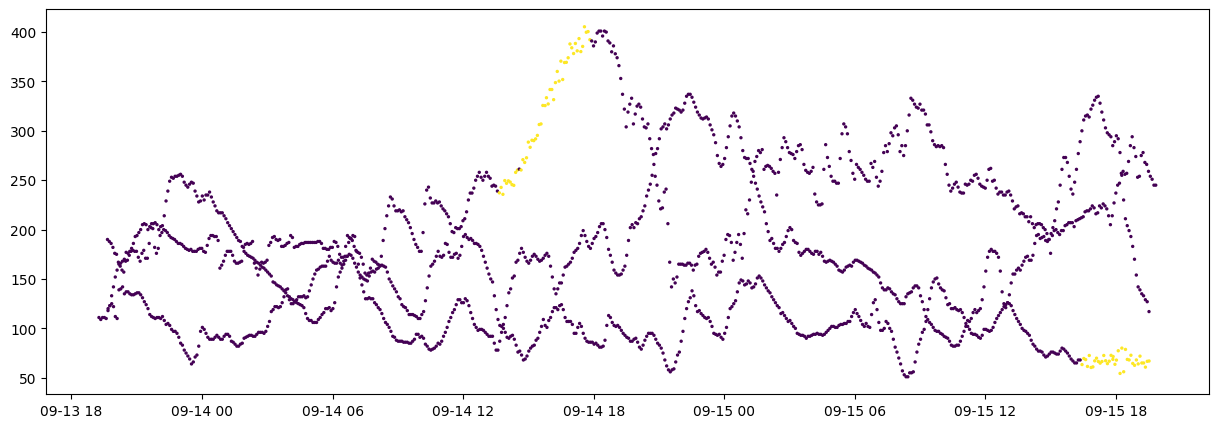

In [26]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
for i in patIDs:
    interp  = data[data.PatientId == i]
    plt.scatter(interp.GlucoseDisplayTime, interp.Value, c=interp.missing, s=2)

# Daily stats

In [9]:
def compressDailyValues(data):
    fs = 1/300
    lower = 70
    upper = 180
    
    median_df = pd.DataFrame(columns=['PatientId', 'Median', 'Mean', 'Std Dev', 'Max', 'Min', 'AreaBelow', 'AreaAbove', 'Date'])
    dates = data.GlucoseDisplayDate.unique()
    
    for date in dates:
        date_sub = data.loc[data.GlucoseDisplayDate == date]
        
        # obtain summary values
        median = np.nanmedian(date_sub.Value)
        mean = np.nanmean(date_sub.Value)
        std = np.nanstd(date_sub.Value)
        maxVal = np.nanmax(date_sub.Value)
        minVal = np.nanmin(date_sub.Value)
        
        # obtain areas above and below recommendation
        upperSegs = date_sub.loc[date_sub.Value > upper].Value - upper
        areaAbove = np.nansum(upperSegs)
        lowerSegs = -(date_sub.loc[date_sub.Value < lower].Value - lower)
        areaBelow = np.nansum(lowerSegs)
        
        sample = [data.iloc[0]["PatientId"], median, mean, std, maxVal, minVal, areaBelow, areaAbove, date]
        
        median_df.loc[len(median_df.index)] = sample
                                   
    return median_df

compressDailyValues(data)

,PatientId,Median,Mean,Std Dev,Max,Min,AreaBelow,AreaAbove,Date
0,9Fob2bu+MwNd3P522PazJ5pIV4l3jvx9Tf98DfxSdoU=,180.0,181.320755,10.229026,202,157,0,243,2022-09-13
1,9Fob2bu+MwNd3P522PazJ5pIV4l3jvx9Tf98DfxSdoU=,186.0,187.660584,94.202791,401,0,2520,9560,2022-09-14
2,9Fob2bu+MwNd3P522PazJ5pIV4l3jvx9Tf98DfxSdoU=,250.0,249.079832,34.766779,333,169,0,16468,2022-09-15
